# Importing Libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from basic_imports import *
import pandas

from math import radians, cos, sin, asin, sqrt

import folium
import datetime
from constants import *
from load_files import *
from scipy.stats import *
from scipy import spatial
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import numpy as np

In [2]:
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

In [3]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [4]:
from tabulate import tabulate

In [10]:
def mean_absolute_percentage_error(y_true, y_pred):
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Loading Files

In [7]:
import pandas as pd
rd = pd.read_csv('road_dict.csv', header=0).to_dict('records')
road_dict = rd[0]

In [11]:
peeps = pd.read_csv("../preprocessing/peeps_new.csv")
peeps = peeps.drop(['Unnamed: 0', 'closest_pm_id'], axis =1)
peeps = peeps.replace({"roadType": road_dict})

In [12]:
london = pd.read_csv("london_test_walk.csv")
london = london.drop(["closest_pm_id", "Unnamed: 0"], axis=1)
london = london.replace({"roadType": road_dict})

In [13]:
mexico = pd.read_csv("../preprocessing/mexico.csv")
mexico = mexico.drop(['walk', 'closest_pm_id'], axis =1)
mexico = mexico.replace({"roadType": road_dict})

In [14]:
leon = mexico[mexico.city.eq(0)]
guadalajara = mexico[mexico.city.eq(1)]

In [14]:
daphne_peeps = pd.concat([daphne, peeps])

In [15]:
datasets = [peeps,leon, guadalajara]

# Baseline

In [190]:
def baseline_results(combinations):
    results = {}
    for i in range(len(combinations)):
        size = len(combinations[i])
        mean = combinations[i]['pm2_5'].mean()
        df = combinations[i].drop(['timestamp','pm2_5'], axis = 1)
        labels = combinations[i][['pm2_5']]
        X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.25, random_state=0)
        
        training_size = len(y_train)
        test_size = len(y_test)
        
        lr = LinearRegression().fit(np.asarray(X_train), np.ravel(y_train))

        pred = lr.predict(X_test)
        

        rmse = np.sqrt(mean_squared_error(np.asarray(y_test), pred))
        mae = mean_absolute_error(np.asarray(y_test), pred)
        mape = mean_absolute_percentage_error(list(y_test.pm2_5), pred)
        results[i] = (training_size,test_size, mean, rmse, mae, mape)
        
    return results, pred


In [191]:
baseline, b_pred = baseline_results(datasets)

In [192]:
print(tabulate([(k,) + v for k,v in baseline.items()], headers = ["combination","training size", "test size","mean","rmse", "mae", "mape"])) 

  combination    training size    test size     mean     rmse       mae      mape
-------------  ---------------  -----------  -------  -------  --------  --------
            0            42169        14057  78.4768  62.2151  43.873    187.63
            1             3876         1293  25.4675  13.2097   9.30766   49.2495
            2             2208          736  22.6717  11.487    7.98932   53.4511


# Gradient Boosted Trees

In [25]:
def bst_results(combinations):
    results = {}
    for i in range(len(combinations)):
        size = len(combinations[i])
        mean = combinations[i]['pm2_5'].mean()
        df = combinations[i].drop(['timestamp','pm2_5'], axis = 1)
        labels = combinations[i][['pm2_5']]
        X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.25, random_state=0)
        
        dtest = xgb.DMatrix(X_test, y_test, feature_names=X_test.columns)
        dtrain = xgb.DMatrix(X_train, y_train,feature_names=X_train.columns)
        
        evallist = [(dtrain, 'train')]
        
        
        bst = xgb.train(param, dtrain, num_round, evallist)
        
        pred = bst.predict(dtest)
        

        rmse = np.sqrt(mean_squared_error(np.asarray(y_test), pred))
        mae = mean_absolute_error(np.asarray(y_test), pred)
        mape = mean_absolute_percentage_error(list(y_test.pm2_5), pred)
        results[i] = (size, mean, rmse, mae, mape)
        
    return results, pred

In [26]:
param = {'verbosity':1,
        'objective':'reg:squarederror',
        'booster':'gbtree',
        'eval_metric' :'mae',
        'learning_rate': 0.1}
num_round = 1000

In [121]:
boosted, gb_pred = bst_results([peeps])

[0]	train-mae:70.38305
[1]	train-mae:63.53016
[2]	train-mae:57.52328
[3]	train-mae:52.30690
[4]	train-mae:47.83051
[5]	train-mae:43.99448
[6]	train-mae:40.65532
[7]	train-mae:37.78213
[8]	train-mae:35.35865
[9]	train-mae:33.14343
[10]	train-mae:31.29935
[11]	train-mae:29.60860
[12]	train-mae:28.12911
[13]	train-mae:26.91012
[14]	train-mae:25.73774
[15]	train-mae:24.76988
[16]	train-mae:23.89117
[17]	train-mae:23.13041
[18]	train-mae:22.41415
[19]	train-mae:21.83098
[20]	train-mae:21.27359
[21]	train-mae:20.75671
[22]	train-mae:20.34130
[23]	train-mae:19.96267
[24]	train-mae:19.57525
[25]	train-mae:19.23946
[26]	train-mae:18.95713
[27]	train-mae:18.67632
[28]	train-mae:18.43061
[29]	train-mae:18.25166
[30]	train-mae:18.04616
[31]	train-mae:17.83310
[32]	train-mae:17.66167
[33]	train-mae:17.45435
[34]	train-mae:17.26749
[35]	train-mae:17.11097
[36]	train-mae:16.92189
[37]	train-mae:16.80470
[38]	train-mae:16.61400
[39]	train-mae:16.51186
[40]	train-mae:16.44944
[41]	train-mae:16.32902
[4

[337]	train-mae:8.77294
[338]	train-mae:8.76858
[339]	train-mae:8.74860
[340]	train-mae:8.74233
[341]	train-mae:8.73794
[342]	train-mae:8.73456
[343]	train-mae:8.71916
[344]	train-mae:8.70940
[345]	train-mae:8.69395
[346]	train-mae:8.68880
[347]	train-mae:8.68405
[348]	train-mae:8.67397
[349]	train-mae:8.67006
[350]	train-mae:8.66776
[351]	train-mae:8.66367
[352]	train-mae:8.64854
[353]	train-mae:8.64539
[354]	train-mae:8.63705
[355]	train-mae:8.63163
[356]	train-mae:8.62009
[357]	train-mae:8.61046
[358]	train-mae:8.60505
[359]	train-mae:8.59954
[360]	train-mae:8.59084
[361]	train-mae:8.58204
[362]	train-mae:8.56237
[363]	train-mae:8.55499
[364]	train-mae:8.54093
[365]	train-mae:8.53111
[366]	train-mae:8.52230
[367]	train-mae:8.51174
[368]	train-mae:8.50273
[369]	train-mae:8.49096
[370]	train-mae:8.48860
[371]	train-mae:8.48193
[372]	train-mae:8.47960
[373]	train-mae:8.47800
[374]	train-mae:8.46875
[375]	train-mae:8.45880
[376]	train-mae:8.44369
[377]	train-mae:8.43768
[378]	train-mae:

[679]	train-mae:6.61217
[680]	train-mae:6.60855
[681]	train-mae:6.60266
[682]	train-mae:6.59728
[683]	train-mae:6.59252
[684]	train-mae:6.59046
[685]	train-mae:6.58734
[686]	train-mae:6.58277
[687]	train-mae:6.57784
[688]	train-mae:6.57325
[689]	train-mae:6.56972
[690]	train-mae:6.56600
[691]	train-mae:6.56394
[692]	train-mae:6.55958
[693]	train-mae:6.55072
[694]	train-mae:6.54708
[695]	train-mae:6.54394
[696]	train-mae:6.53864
[697]	train-mae:6.53351
[698]	train-mae:6.53200
[699]	train-mae:6.52562
[700]	train-mae:6.52231
[701]	train-mae:6.52142
[702]	train-mae:6.51771
[703]	train-mae:6.51278
[704]	train-mae:6.50692
[705]	train-mae:6.49975
[706]	train-mae:6.49720
[707]	train-mae:6.49464
[708]	train-mae:6.49165
[709]	train-mae:6.48424
[710]	train-mae:6.48053
[711]	train-mae:6.47663
[712]	train-mae:6.47478
[713]	train-mae:6.47069
[714]	train-mae:6.46797
[715]	train-mae:6.46602
[716]	train-mae:6.46231
[717]	train-mae:6.45960
[718]	train-mae:6.45253
[719]	train-mae:6.44900
[720]	train-mae:

In [122]:
print(tabulate([(k,) + v for k,v in boosted.items()], headers = ["combination", "size","mean","rmse", "mae", "mape"])) 

  combination    size     mean     rmse      mae     mape
-------------  ------  -------  -------  -------  -------
            0   56226  78.4768  16.3238  8.59884  27.2879


In [30]:
gb_pred

array([14.90274 , 12.075665, 13.350771, ..., 21.398186, 18.558874,
       17.295265], dtype=float32)

# Random Forests

In [32]:
def rf_results(combinations):
    results = {}
    for i in range(len(combinations)):
        size = len(combinations[i])
        mean = combinations[i]['pm2_5'].mean()
        df = combinations[i].drop(['timestamp','pm2_5'], axis = 1)
        labels = combinations[i][['pm2_5']]
        X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.25, random_state=0)
        
        regr = RandomForestRegressor(n_estimators=100,max_depth=50, random_state=0)
        regr.fit(np.asarray(X_train), np.ravel(y_train))
        

        pred = regr.predict(X_test)

        rmse = np.sqrt(mean_squared_error(np.asarray(y_test), pred))
        mae = mean_absolute_error(np.asarray(y_test), pred)
        mape = mean_absolute_percentage_error(list(y_test.pm2_5), pred)
        results[i] = (size, mean, rmse, mae, mape)
        
    return results, pred

In [123]:
random_forest, rf_pred = rf_results([peeps])

In [124]:
print(tabulate([(k,) + v for k,v in random_forest.items()], headers = ["combination", "size","mean","rmse", "mae", "mape"])) 

  combination    size     mean     rmse      mae     mape
-------------  ------  -------  -------  -------  -------
            0   56226  78.4768  14.7956  6.03923  15.8552


# Extra Trees

In [170]:
def et_results(combinations):
    results = {}
    for i in range(len(combinations)):
        size = len(combinations[i])
        mean = combinations[i]['pm2_5'].mean()
        df = combinations[i].drop(['timestamp','pm2_5', 'roadType'], axis = 1)
        labels = combinations[i][['pm2_5']]
        X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.25, random_state=0)
        
        
        reg = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(np.asarray(X_train), np.ravel(y_train))         

        pred = reg.predict(X_test)

        rmse = np.sqrt(mean_squared_error(np.asarray(y_test), pred))
        mae = mean_absolute_error(np.asarray(y_test), pred)
        mape = mean_absolute_percentage_error(list(y_test.pm2_5), pred)
        results[i] = (size, mean, rmse, mae, mape)
        
    return results#, pred, np.array(y_test.pm2_5)

In [171]:
extra_trees = et_results([peeps])

In [172]:
print(tabulate([(k,) + v for k,v in extra_trees.items()], headers = ["combination", "size","mean","rmse", "mae", "mape"])) 

  combination    size     mean     rmse      mae     mape
-------------  ------  -------  -------  -------  -------
            0   56226  78.4768  12.4305  4.94952  12.1887


# Jitter Plots

In [69]:
import seaborn as sns

In [173]:
ba = pd.DataFrame(b_pred, columns =['PM2.5'])
gb = pd.DataFrame(gb_pred, columns=['PM2.5'])
rf = pd.DataFrame(rf_pred, columns=['PM2.5'])
et = pd.DataFrame(et_pred, columns=['PM2.5'])
ta = pd.DataFrame(target, columns=['PM2.5'])
ba['baseline'] = 'Linear Regression'
gb['baseline'] = 'GB Trees'
rf['baseline'] = 'RFSI'
et['baseline'] = 'Extra Trees'
ta['baseline'] = 'Target'

In [106]:
leon_da = pd.concat([dd, gb, rf, et, ta])

In [115]:
gdl_da = pd.concat([dd, gb, rf, et, ta])

In [174]:
peeps_da = pd.concat([dd, gb, rf, et, ta])

In [175]:
peeps_da.to_pickle("peeps_da.pkl")

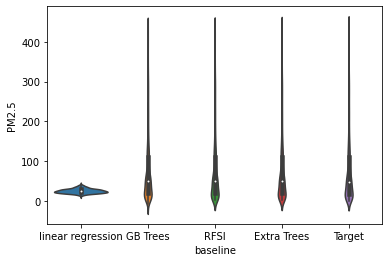

In [140]:
ax = sns.violinplot(x="baseline", y="PM2.5", data=peeps_da, whis=np.inf)
#ax = sns.stripplot(x="baseline", y="PM2.5", data=da, color=".3")

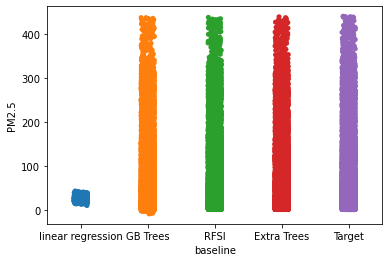

In [176]:
sns.stripplot(x="baseline", y="PM2.5", data=peeps_da)
plt.savefig("peeps_jitter.png")

# Feature Importance

In [52]:
def feature_importance(dataset):
    df = dataset.drop(['timestamp','pm2_5', 'hour_of_day', 'day_of_week'], axis = 1)
    labels = dataset[['pm2_5']]
    X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.25, random_state=0)
    reg = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(np.asarray(X_train), np.ravel(y_train))        
    
    features = X_train.columns
    importances = reg.feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize=(16,8))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Gini Importance')
    plt.ylabel('Feature name')
    plt.show()

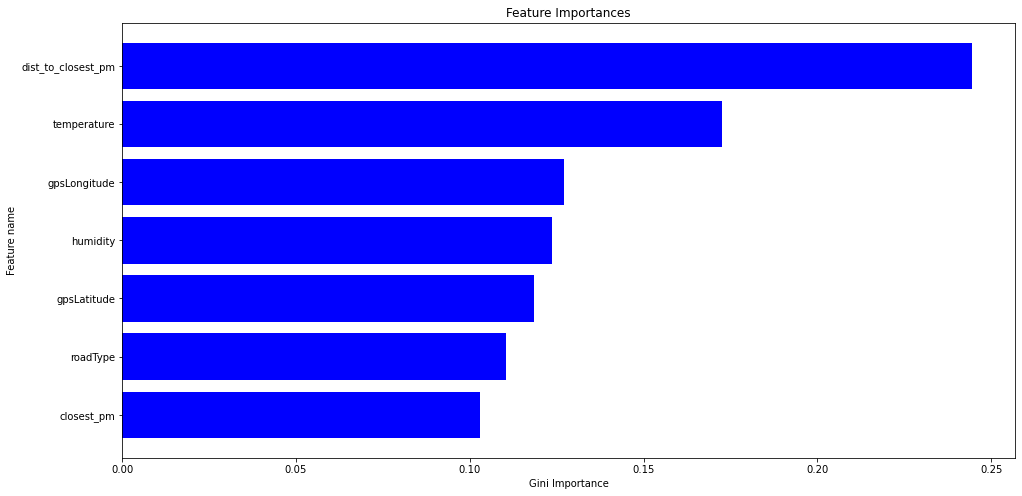

In [53]:
feature_importance(peeps)

# Training set size experiment

In [196]:
peeps

,timestamp,pm2_5,hour_of_day,day_of_week,temperature,humidity,gpsLongitude,gpsLatitude,closest_pm,dist_to_closest_pm,roadType
0,2018-12-17 11:26:00+05:30,67.496367,11,0,22.700000,59.400000,77.207692,28.629123,165.031754,18.170508,3
1,2018-12-17 11:27:00+05:30,63.740506,11,0,22.900000,58.600002,77.208000,28.628589,113.139107,6.329535,3
2,2018-12-17 11:28:00+05:30,66.239628,11,0,23.050000,57.400000,77.208225,28.633647,113.139107,6.800481,2
3,2018-12-17 11:29:00+05:30,63.791646,11,0,23.214286,57.571429,77.207692,28.630761,113.139107,6.550498,3
4,2018-12-17 11:30:00+05:30,62.444813,11,0,23.428572,58.300000,77.208052,28.631000,113.139107,6.555037,3
...,...,...,...,...,...,...,...,...,...,...,...
56221,2019-04-18 05:33:00+05:30,21.541079,5,3,28.316668,50.900000,77.389861,28.665445,49.508865,0.120198,4
56222,2019-04-18 05:34:00+05:30,21.242035,5,3,28.400000,50.900000,77.389861,28.665445,80.796776,0.120194,4
56223,2019-04-18 05:35:00+05:30,21.579753,5,3,28.400000,50.900000,77.389861,28.665445,48.465637,0.120187,4
56224,2019-04-18 05:36:00+05:30,21.785348,5,3,28.420000,50.940000,77.389861,28.665445,48.465637,0.120183,4


In [243]:
def tsse_results(dataset):
    results = {}
    for i in range(1, 22):
        #f_dataset = dataset.sample(n=(i*2000))
        
        #size = len(dataset)
        #mean = dataset['pm2_5'].mean()
        df = dataset.drop(['timestamp','pm2_5', 'roadType'], axis = 1)
        labels = dataset[['pm2_5']]
        X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.25, random_state=0)
        
        idx = np.random.choice(np.arange(len(X_train)), (i*2000), replace=False)
        X_train = X_train.iloc[idx]
        y_train = y_train.iloc[idx]
        
        
        reg = ExtraTreesRegressor(max_depth=50,n_estimators=200, random_state=0).fit(np.asarray(X_train), np.ravel(y_train))         

        pred = reg.predict(X_test)

        
        mape = mean_absolute_percentage_error(list(y_test.pm2_5), pred)
        results[i*2000] = mape
        
    return results#, pred, np.array(y_test.pm2_5)

In [244]:
tsse2_peeps = tsse_results(peeps)

In [245]:
tsse2_peeps

{2000: 50.45374267072085,
 4000: 35.95537976018348,
 6000: 32.173732067863455,
 8000: 27.08830689833609,
 10000: 23.542061032364497,
 12000: 23.298841839369487,
 14000: 20.54354478826369,
 16000: 18.96534467423624,
 18000: 17.697864338507642,
 20000: 17.065033126494516,
 22000: 16.307455976554547,
 24000: 16.072012316144317,
 26000: 14.634016473482522,
 28000: 14.289153083585235,
 30000: 13.74942790296351,
 32000: 13.154318890248536,
 34000: 13.037442719629185,
 36000: 12.950316879761786,
 38000: 12.608886855407292,
 40000: 12.353290041758608,
 42000: 12.19087707518727}

In [246]:
delhi_exp2_df = pd.DataFrame.from_dict(tsse2_peeps, orient = 'index')

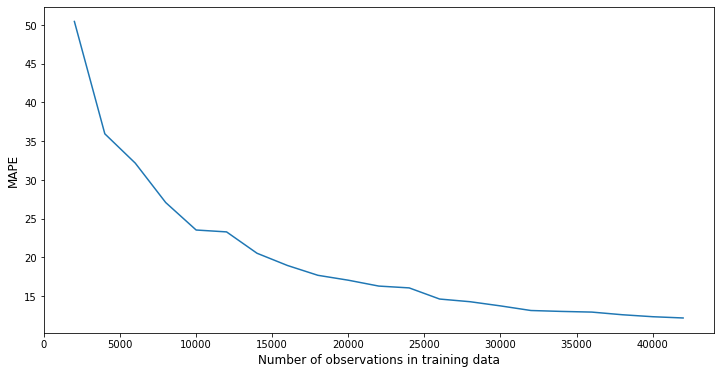

In [259]:
ax2 = delhi_exp2_df.plot(figsize=(12, 6))
ax2.set_ylabel("MAPE",fontsize=12)
ax2.set_xlabel("Number of observations in training data",fontsize=12)
ax2.get_legend().remove()
#plt.xticks(range(5000, 50000, 5000))

#plt.axvline(delhi_exp2_df[0].idxmin(), color='red', linestyle='dashed')
plt.savefig('delhi_training_size_exp.png', dpi=300)